<a href="https://colab.research.google.com/github/ProfEddie/HypCLIP/blob/perceiver/lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from model.dctModel import DCTLAVISLIPWithQueue 
from model.modules.dct import dct, idct, dc_transform
from lavis.datasets.builders import load_dataset
from trainer_queue import MyTrainer as LavisTrainer 
from utils.data_utils import  get_loaders
from lavis.models import load_model_and_preprocess
from transformers import AutoProcessor, AutoModel
import torch
import torch.nn as nn
import torch.nn.functional as  F
import matplotlib.pyplot as plt


/home/jarvis/anaconda3/envs/hada-v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
COCO_PATH = "/mnt/data/itr_dataset/dataset/coco/images"
FLICKR_PATH = "/mnt/data/itr_dataset/dataset/flickr30k/flickr30k_images"
dataset = load_dataset("flickr30k", vis_path=FLICKR_PATH, cfg_path=None)
model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "flickr", is_eval=False)

Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/train.json
Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/val.json
Using downloaded and verified file: /mnt/data/itr_dataset/dataset/flickr30k/annotations/test.json


In [3]:

train_loader, val_loader, test_loader = get_loaders(
    40, 
    dataset,
    vis_processor=vis_processors['eval'],
    txt_processor=txt_processors['eval'],
    tokenizer=model.tokenizer,
)

In [4]:

def plot_hidden_states(hidden_states, filtered=False):
  for hidden_state in hidden_states:
    hidden_state=hidden_state.permute(1,0,2)
    x_dct = dct(hidden_state.transpose(0,2), norm='ortho').transpose(0,2)
    if not filtered:
      numpy_array = ((x_dct.permute(1,0,2).mean(0).mean(1))).cpu().detach().numpy()
    else:
      numpy_array = ((x_dct.permute(1,0,2).mean(0).mean(1)))[:350].cpu().detach().numpy()
    plt.figure(figsize=(10, 2))

    # plt.imshow(numpy_array, cmap='viridis')  # You can choose a different colormap
    plt.plot(numpy_array)# You can choose a different colormap
    # plt.colorbar()
    plt.show()



In [5]:
from lavis.models import load_model_and_preprocess
model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "flickr", is_eval=False)

In [6]:
from model.modules.dct_blip import DCTLAVISBlip
wrapper = DCTLAVISBlip(model)
wrapper.eval()

DCTLAVISBlip(
  (vision_model): VisionTransformerEncoder(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
   

  0%|          | 0/3625 [00:00<?, ?it/s]


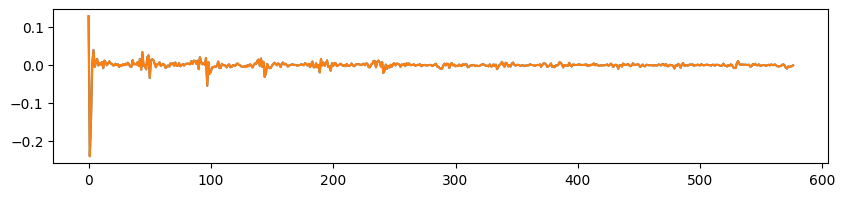

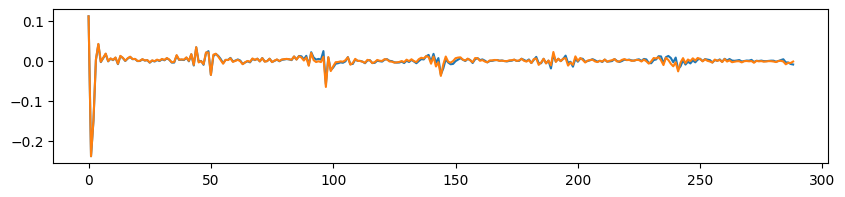

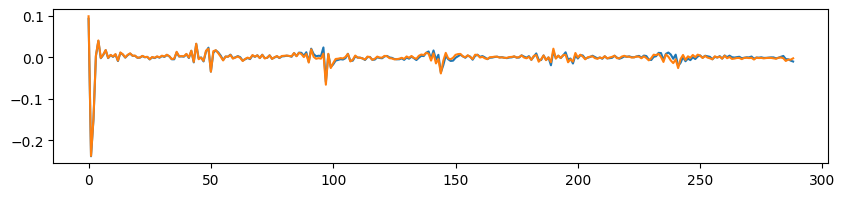

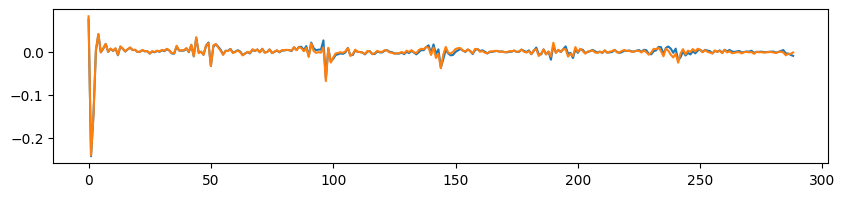

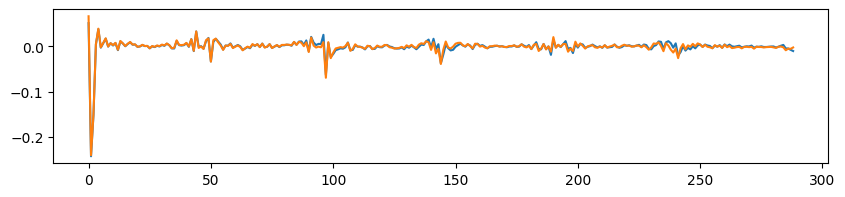

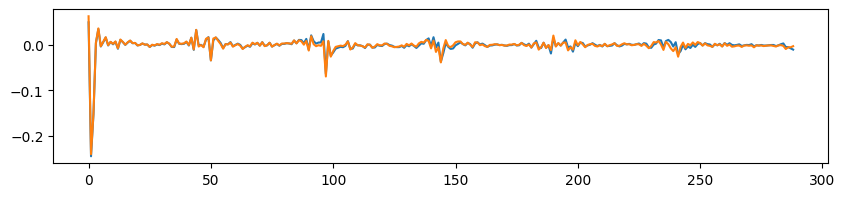

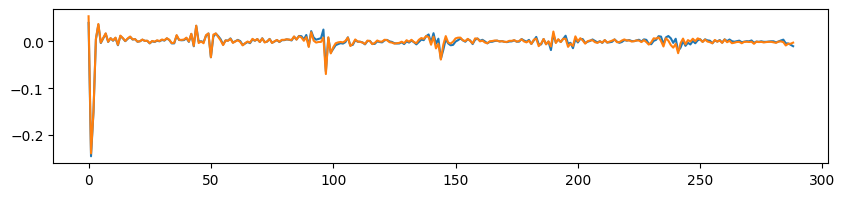

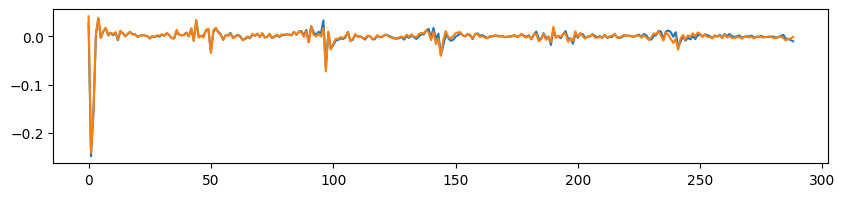

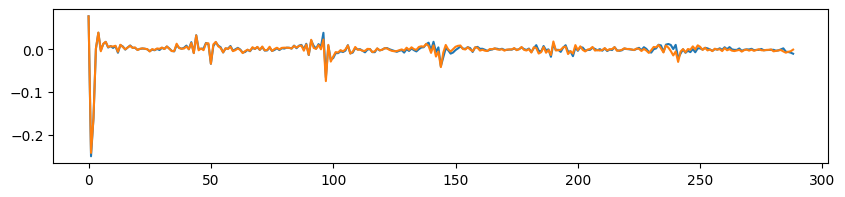

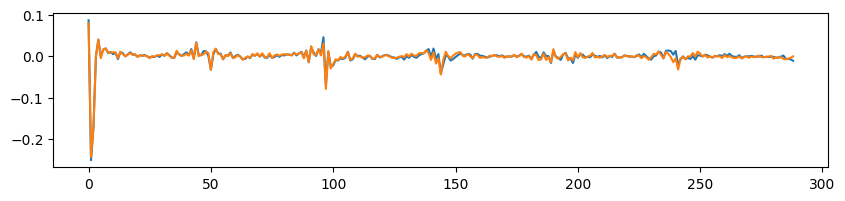

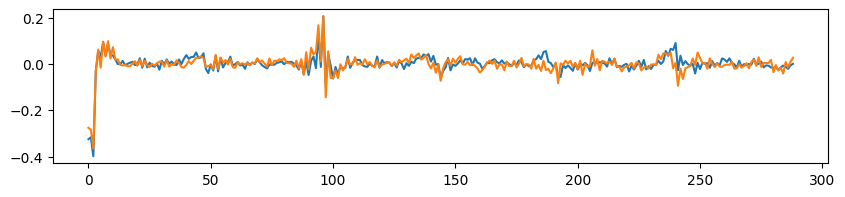

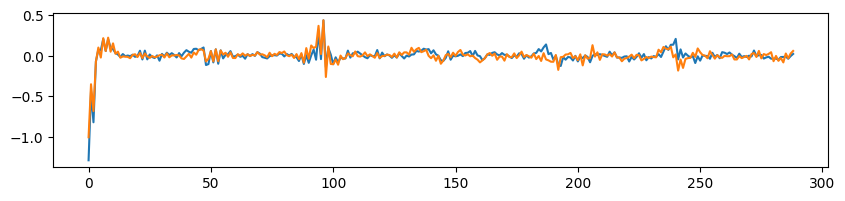

In [22]:
from tqdm.auto import tqdm

for batch in tqdm(train_loader):
    wrapper.eval()
    break
with torch.no_grad():
    # print(batch['pixel_values'].shape)
    _,_, hidden_states = wrapper(pixel_values=batch['pixel_values'], apply_fourier=False)
    _,_, filtered_hidden_states = wrapper(pixel_values=batch['pixel_values'], apply_fourier=True)
    for i in range(len(filtered_hidden_states)):
        filtered_hidden_state = filtered_hidden_states[i].permute(1,0,2)
        hidden_state = hidden_states[i].permute(1,0,2)
        x_dct_filtered = dct(filtered_hidden_state.transpose(0,2), norm='ortho').transpose(0,2)
        x_dct = dct(hidden_state.transpose(0,2), norm='ortho').transpose(0,2)[:x_dct_filtered.shape[0],:, :]
        x_dct_filtered =x_dct_filtered.permute(1,0,2)
        x_dct = x_dct.permute(1,0,2)
        x_dct_filtered_mean =x_dct_filtered.mean(0).mean(1)
        x_dct_mean = x_dct.mean(0).mean(1)
        
        plt.figure(figsize=(10, 2))
        plt.plot(x_dct_mean.cpu().detach().numpy())
        plt.plot(x_dct_filtered_mean.cpu().detach().numpy())
        plt.show()
      

# plot_hidden_states(hidden_states, filtered=True)

In [13]:
# with torch.no_grad():
#     print(batch['pixel_values'].shape)
#     _,_, hidden_states = wrapper(pixel_values=batch['pixel_values'], apply_fourier=True)
# plot_hidden_states(hidden_states)